#### Objective:
This script implements **user-based collaborative filtering** to recommend movies for a given user. The similarity is computed using **cosine similarity** on the user-item ratings matrix, and the output is a ranked list of recommended movies with their predicted scores.

#### Step 1: User-Item Matrix
Construct the user-item matrix $R \in \mathbb{R}^{m \times n}$, where:
- $m$: Number of users
- $n$: Number of movies
- $R_{ij}$: Rating given by user $i$ to movie $j$ (or $0$ if not rated).

#### Step 2: Cosine Similarity
The similarity $S_{ij}$ between users $i$ and $j$ is computed as:
$S_{ij} = \frac{\vec{R}_i \cdot \vec{R}_j}{\|\vec{R}_i\| \|\vec{R}_j\|}$

Where:
- $\vec{R}_i$: Row vector representing ratings for user $i$.
- $\|\vec{R}_i\|$: Euclidean norm of $\vec{R}_i$, given by $\sqrt{\sum_k R_{ik}^2}$.

#### Step 3: Similarity Scores for Target User
For a target user $u$, compute:
$\text{Scores} = \{S_{uj} \,|\, j \neq u\}$

#### Step 4: Ratings from Similar Users
Select the top $N$ most similar users to the target user, retrieve their ratings, and aggregate these to estimate scores for movies not yet rated by the target user.

#### Step 5: Recommend Movies
For each unrated movie:
1. Compute the average predicted rating using ratings from the top similar users.
2. Rank movies by their predicted scores.
3. Return the top $M$ recommendations for the target user.



Base Data Tables:
Movies Table: 9742 rows, 3 columns
Ratings Table: 100836 rows, 4 columns

Movies Table (Sample):
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Table (Sample):
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Step 1: Creating User-Item Matrix..

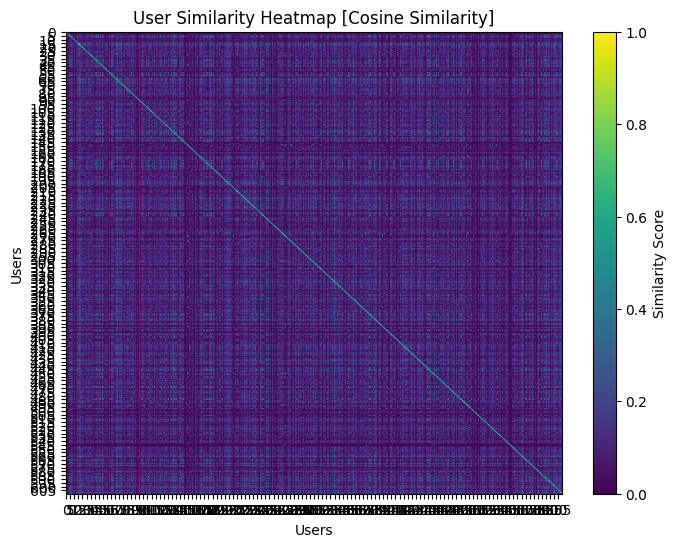


Step 4: Getting Similarity Scores for Target User 1...

Top Similar Users:
userId
1      1.000000
266    0.357408
313    0.351562
368    0.345127
57     0.345034
91     0.334727
Name: 1, dtype: float64

Step 5: Extracting Ratings from Top Similar Users...

Ratings by Top Similar Users (First Few Rows):
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
266         2.0     0.0     0.0     0.0     0.0     4.0     0.0     0.0   
313         0.0     0.0     0.0     0.0     0.0     3.0     0.0     0.0   
368         0.0     0.0     3.0     0.0     0.0     4.0     0.0     0.0   
57          5.0     0.0     0.0     0.0     0.0     3.0     0.0     0.0   
91          4.0     3.0     3.0     0.0     0.0     5.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
266      

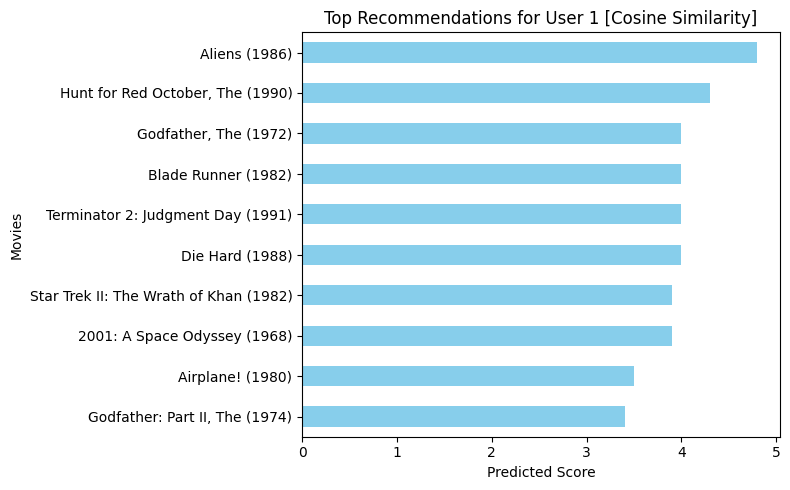

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Hyperparameters and Variables
path = 'data/ml-latest-small/'  # Path to dataset
movies_path = path + "movies.csv"
ratings_path = path + "ratings.csv"
target_user_id = 1  # ID of the target user
min_ratings = 0  # Minimum ratings to consider a movie (0 = no filtering)
similarity_metric = 'cosine'  # Metric for similarity ('cosine', 'pearson', 'jaccard')
top_n_users = 5  # Number of similar users to consider
top_n_recommendations = 10  # Number of recommendations to return

# Load datasets
movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)

# Describe base data tables
print("\nBase Data Tables:")
print(f"Movies Table: {movies.shape[0]} rows, {movies.shape[1]} columns")
print(f"Ratings Table: {ratings.shape[0]} rows, {ratings.shape[1]} columns")

# Display sample data
print("\nMovies Table (Sample):")
print(movies.head(5))
print("\nRatings Table (Sample):")
print(ratings.head(5))

# Step 1: Create a User-Item Matrix
print("\nStep 1: Creating User-Item Matrix...")
user_item_matrix = ratings.pivot(index="userId", columns="movieId", values="rating")

# Display a sample of the User-Item Matrix
print("User-Item Matrix (First 5 Users, First 5 Movies):")
print(user_item_matrix.iloc[:5, :5])

# Step 2: Fill Missing Values with 0
print("\nStep 2: Filling Missing Values with 0...")
user_item_matrix = user_item_matrix.fillna(0)

# Step 3: Compute Similarity Between Users
print("\nStep 3: Computing Similarity Between Users...")
if similarity_metric == 'cosine':
    user_similarity = cosine_similarity(user_item_matrix)
elif similarity_metric == 'pearson':
    user_similarity = user_item_matrix.T.corr().values  # Pearson correlation
elif similarity_metric == 'jaccard':
    binary_matrix = (user_item_matrix > 0).astype(int)  # Convert to binary
    intersection = binary_matrix.dot(binary_matrix.T)
    row_sums = binary_matrix.sum(axis=1).values[:, None]
    union = row_sums + row_sums.T - intersection
    user_similarity = intersection / union
else:
    raise ValueError(f"Unsupported similarity metric: {similarity_metric}")

similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
print("\nUser Similarity Matrix (First 5 Users):")
print(similarity_df.iloc[:5, :5])

# Visualize user similarity heatmap
print("\nVisualizing User Similarity Heatmap...")
plt.figure(figsize=(8, 6))
plt.imshow(user_similarity, cmap="viridis", aspect="auto")
plt.colorbar(label="Similarity Score")
plt.title(f"User Similarity Heatmap [{similarity_metric.capitalize()} Similarity]")
plt.xlabel("Users")
plt.ylabel("Users")
plt.xticks(range(0, len(user_item_matrix.index), 5))
plt.yticks(range(0, len(user_item_matrix.index), 5))
plt.show()

# Step 4: Get Similarity Scores for the Target User
print(f"\nStep 4: Getting Similarity Scores for Target User {target_user_id}...")
target_user_similarity = similarity_df[target_user_id].sort_values(ascending=False)
print("\nTop Similar Users:")
print(target_user_similarity.head(top_n_users + 1))  # Include the target user itself

# Step 5: Get Ratings from Similar Users
print("\nStep 5: Extracting Ratings from Top Similar Users...")
top_similar_users = target_user_similarity.index[1:top_n_users + 1]  # Exclude the target user itself
similar_users_ratings = user_item_matrix.loc[top_similar_users]

print("\nRatings by Top Similar Users (First Few Rows):")
print(similar_users_ratings.head())

# Step 6: Recommend Movies
print("\nStep 6: Finding Movies the Target User Hasn't Rated...")
target_user_movies = user_item_matrix.loc[target_user_id]
unrated_movies = target_user_movies[target_user_movies == 0].index
print(f"\nUnrated Movies for User {target_user_id}: {list(unrated_movies[:5])}")

# Step 7: Calculate Recommendations
print("\nStep 7: Calculating Recommendations...")
movie_scores = similar_users_ratings[unrated_movies].mean(axis=0).sort_values(ascending=False).head(top_n_recommendations)
print("\nMovie Scores for Unrated Movies:")
print(movie_scores)

# Step 8: Map Movie IDs to Titles
print("\nStep 8: Mapping Movie IDs to Titles...")
movie_titles = movies.set_index("movieId")["title"]
recommendations = pd.DataFrame({
    "Movie": movie_titles.loc[movie_scores.index],
    "Predicted Score": movie_scores.values
})
print(f"\nRecommendations for User {target_user_id}:")
print(recommendations)

# Visualize Recommendations
print("\nVisualizing Recommendations...")
plt.figure(figsize=(8, 5))
recommendations.set_index("Movie")["Predicted Score"].plot(kind="barh", color="skyblue")
plt.title(f"Top Recommendations for User {target_user_id} [{similarity_metric.capitalize()} Similarity]")
plt.xlabel("Predicted Score")
plt.ylabel("Movies")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()